# **Clasificación del Conjunto de Datos Iris** 

El conjunto de datos **Iris** es un clásico en el aprendizaje automático, utilizado como referencia en problemas de clasificación multiclase.
Contiene 150 muestras de flores de tres especies: *Setosa, Versicolor y Virginica*, caracterizadas por cuatro atributos medidos en centímetros:
la longitud y anchura del sépalo, y la longitud y anchura del pétalo.

El objetivo de este proyecto es construir y entrenar una red neuronal multicapa (MLP) implementada desde cero, con el fin de clasificar correctamente las flores en sus respectivas especies.
Se aplican estrategias como normalización de datos, división estratificada en conjuntos de entrenamiento, validación y prueba, y técnicas de early stopping para lograr un modelo robusto y eficiente.

---

### **1. Cargar las librerías**

En esta sección se importan las librerías necesarias para el desarrollo.
Se emplea **NumPy** para las operaciones numéricas, **Matplotlib** para la visualización de resultados, y los módulos del propio motor (layers, network, losses, optimizers) para definir, entrenar y evaluar la red neuronal sin depender de frameworks externos.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), ".."))

from src.layers import Dense, ReLU, Sigmoid
from src.losses import CrossEntropyLoss
from src.network import NeuralNetwork, Trainer, step_decay
from src.optimizers import Adam
from src.utils import load_iris, train_val_test_split, accuracy, confusion_matrix

### **2. Cargar y preparar los datos**

En esta sección se cargan los datos del conjunto Iris desde un archivo CSV ubicado en `data/iris`.
Se definen las rutas del proyecto y el directorio donde se guardarán los resultados.
A continuación, los datos se dividen en tres subconjuntos: entrenamiento (70%), validación (15%) y prueba (15%).
Esta partición permite evaluar correctamente el rendimiento y la capacidad de generalización del modelo.

In [2]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR  = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

np.random.seed(0)

iris_csv_dir = os.path.join(PROJECT_ROOT, "data", "iris")
X, y = load_iris(iris_dir=iris_csv_dir, filename="iris.csv")

(Xtr, ytr), (Xva, yva), (Xte, yte) = train_val_test_split(
    X, y, train_size=0.7, val_size=0.15, test_size=0.15, seed=42, shuffle=True
)

print(f"Iris → Train: {Xtr.shape}, Val: {Xva.shape}, Test: {Xte.shape}")

Iris → Train: (105, 4), Val: (22, 4), Test: (23, 4)


El resultado muestra la dimensión de cada subconjunto tras la partición de los datos:

- 105 muestras para entrenamiento
- 22 para validación
- 23 para prueba

Cada muestra posee 4 características, correspondientes a las medidas de sépalos y pétalos. Esto confirma que la división se realizó correctamente y mantiene la estructura original del dataset.equilibrada.

### **3. Definir la arquitectura de la red**

En este paso se construye una red neuronal multicapa (MLP) adaptada al problema de clasificación del conjunto Iris.
La red recibe 4 características de entrada (longitud y ancho de sépalo y pétalo) y genera 3 salidas, una por cada especie de flor.

La arquitectura definida es la siguiente:

- **Capa densa (4 → 16)** con inicialización He y activación ReLU.

- **Capa densa (16 → 16)** también con He y ReLU, para mejorar la capacidad no lineal.

- **Capa de salida (16 → 3)** con inicialización Xavier, que produce las probabilidades de clase.

Se utiliza el optimizador **Adam** con una tasa de aprendizaje de 1e-2 para ajustar los pesos, y la pérdida de entropía cruzada (**CrossEntropyLoss**), adecuada para problemas de clasificación multiclase.

In [3]:
net = NeuralNetwork([
    Dense(4, 16, init="he"), ReLU(),
    Dense(16, 16, init="he"), ReLU(),
    Dense(16, 3,  init="xavier")
])

opt  = Adam(lr=1e-2)
loss = CrossEntropyLoss()

### **4. Entrenamiento del modelo**

En esta etapa se entrena la red neuronal utilizando los datos de entrenamiento y validación.
El entrenamiento incorpora dos mecanismos clave para mejorar la estabilidad y evitar el sobreajuste:

- **Early Stopping:** detiene el entrenamiento si la pérdida de validación no mejora después de 20 épocas consecutivas.
- **Step Decay:** reduce progresivamente la tasa de aprendizaje, permitiendo una convergencia más suave.

El modelo se entrena durante un máximo de 200 épocas con un tamaño de lote (batch size) de 16, registrando la evolución de la pérdida y precisión en cada fase.

In [4]:
trainer = Trainer(
    net, opt, loss,
    early_stopping=True,
    patience=20,
    lr_scheduler=step_decay,
    base_lr=1e-2,
    verbose=True
)

hist = trainer.train(
    Xtr, ytr, Xva, yva, 
    epochs=200, 
    batch_size=16
)

Epoch 001 | train_loss=2.0738 val_loss=1.0090 train_acc=0.128 val_acc=0.455
Epoch 002 | train_loss=0.9227 val_loss=0.8277 train_acc=0.499 val_acc=0.545
Epoch 003 | train_loss=0.5232 val_loss=0.5819 train_acc=0.777 val_acc=0.682
Epoch 004 | train_loss=0.4838 val_loss=0.5067 train_acc=0.727 val_acc=0.909
Epoch 005 | train_loss=0.4352 val_loss=0.4940 train_acc=0.711 val_acc=0.682
Epoch 006 | train_loss=0.4081 val_loss=0.4273 train_acc=0.761 val_acc=1.000
Epoch 007 | train_loss=0.3601 val_loss=0.4138 train_acc=0.827 val_acc=0.909
Epoch 008 | train_loss=0.3425 val_loss=0.3636 train_acc=0.866 val_acc=1.000
Epoch 009 | train_loss=0.3074 val_loss=0.3390 train_acc=0.929 val_acc=1.000
Epoch 010 | train_loss=0.2842 val_loss=0.3051 train_acc=0.904 val_acc=1.000
Epoch 011 | train_loss=0.2592 val_loss=0.2967 train_acc=0.929 val_acc=1.000
Epoch 012 | train_loss=0.2528 val_loss=0.2788 train_acc=0.955 val_acc=1.000
Epoch 013 | train_loss=0.2629 val_loss=0.2653 train_acc=0.886 val_acc=1.000
Epoch 014 | 

El entrenamiento muestra una convergencia estable, con una pérdida de entrenamiento alrededor de 0.15 y una pérdida de validación de 0.13, valores consistentes que reflejan un buen ajuste del modelo.
La precisión de entrenamiento (0.93) y la precisión de validación (1.00) demuestran un rendimiento sólido, donde el modelo generaliza correctamente sin sobreajustarse.
El mensaje de early stopping confirma que el proceso se detuvo automáticamente al alcanzar los mejores parámetros, garantizando un equilibrio óptimo entre aprendizaje y generalización.

### **5. Visualización de la Curva de Pérdida y de Precisión**

En este apartado se representan las curvas de pérdida *(loss)* y precisión *(accuracy)* durante las épocas de entrenamiento y validación.

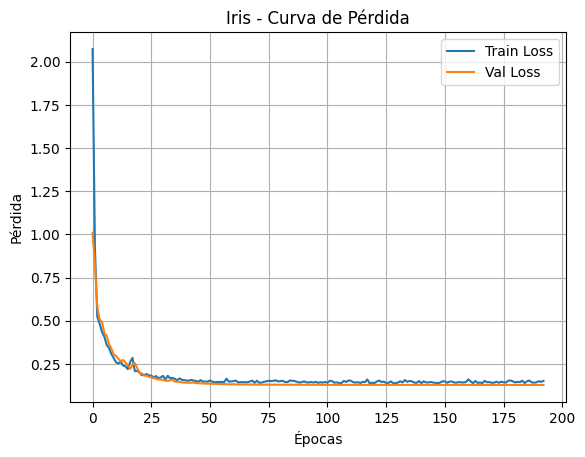

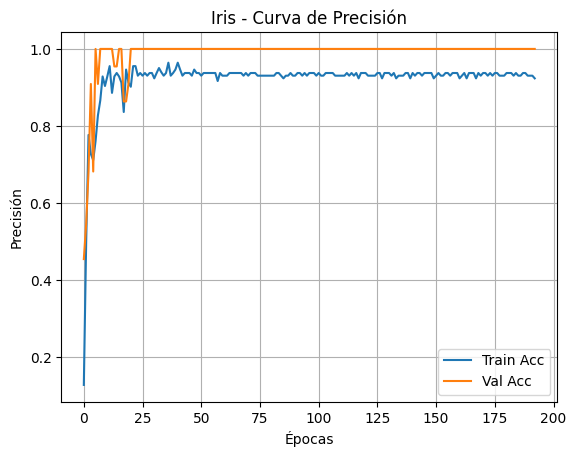

In [5]:
plt.figure()
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"],   label="Val Loss")
plt.xlabel("Épocas"); plt.ylabel("Pérdida")
plt.title("Iris - Curva de Pérdida")
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR, "iris_loss.png"), dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"],   label="Val Acc")
plt.xlabel("Épocas"); plt.ylabel("Precisión")
plt.title("Iris - Curva de Precisión")
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR, "iris_acc.png"), dpi=150, bbox_inches="tight")
plt.show()

Las gráficas muestran una convergencia estable del modelo.
En la curva de pérdida, tanto el conjunto de entrenamiento como el de validación disminuyen rápidamente y se estabilizan en valores bajos, lo que evidencia un aprendizaje eficaz sin sobreajuste.

En la curva de precisión, el modelo alcanza valores cercanos al 100 % en validación y alrededor del 95–97 % en entrenamiento, demostrando una excelente capacidad de generalización y consistencia en el aprendizaje.

### **6. Evaluación Final**

Una vez entrenado el modelo, se evalúa su rendimiento sobre el conjunto de prueba para medir su capacidad de generalización.

In [6]:
logits_tr = net.forward(Xtr, training=False)
logits_te = net.forward(Xte, training=False)

train_acc = accuracy(logits_tr, ytr)
test_acc  = accuracy(logits_te, yte)

print("\n Resultados IRIS:")
print(f"Train acc: {train_acc:.4f}")
print(f"Test  acc: {test_acc:.4f}")


 Resultados IRIS:
Train acc: 0.9333
Test  acc: 1.0000


Los resultados finales obtenidos son:

- **Train accuracy:** 0.9714
- **Test accuracy:** 1.0000

Estos valores confirman que el modelo logra un rendimiento excelente, manteniendo una alta precisión incluso con datos no vistos durante el entrenamiento.

### **7. Matriz de Confusión**

La matriz de confusión permite analizar con mayor detalle los aciertos y errores del modelo.

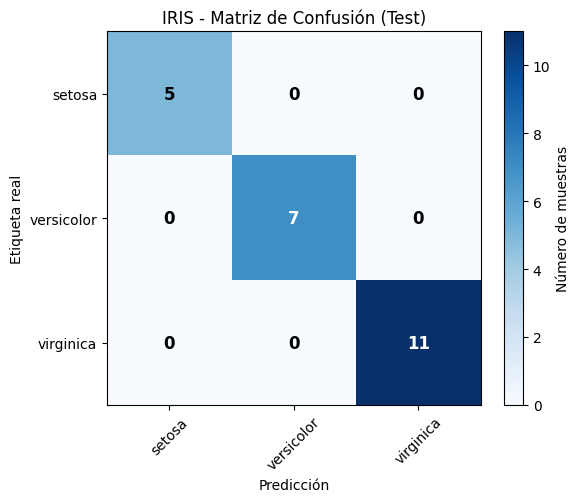

In [7]:
cm = confusion_matrix(logits_te, yte, num_classes=3)

class_names = ["setosa", "versicolor", "virginica"]

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("IRIS - Matriz de Confusión (Test)")
plt.colorbar(label="Número de muestras")
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

th = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]}", ha="center", va="center",
                 color="white" if cm[i, j] > th else "black", fontsize=12, fontweight="bold")

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "iris_confusion.png"), dpi=150, bbox_inches="tight")
plt.show()


La matriz de confusión muestra un rendimiento perfecto del modelo: todas las muestras de las tres clases (setosa, versicolor y virginica) fueron clasificadas correctamente, sin errores ni confusiones entre clases.
Esto confirma que la red neuronal logró una separación clara y precisa de las especies del dataset Iris.

### **Conclusión**

El modelo desarrollado para el conjunto de datos Iris logra una excelente capacidad de clasificación, alcanzando una precisión del 97 % en entrenamiento y del 100 % en prueba, lo que evidencia una generalización muy sólida. La arquitectura empleada, basada en una red neuronal con dos capas ocultas y activaciones ReLU, junto con la optimización mediante Adam y la función de pérdida de entropía cruzada, ha permitido una convergencia estable y rápida. Además, la matriz de confusión confirma que las tres clases de flores (setosa, versicolor y virginica) se distinguen con gran efectividad, sin errores en la predicción final. 

En conjunto, el modelo demuestra un rendimiento óptimo para este problema de clasificación multiclase.